# AEROSP 520 Compressible Flow: Homework 3
Jason Chen

## Problem 1
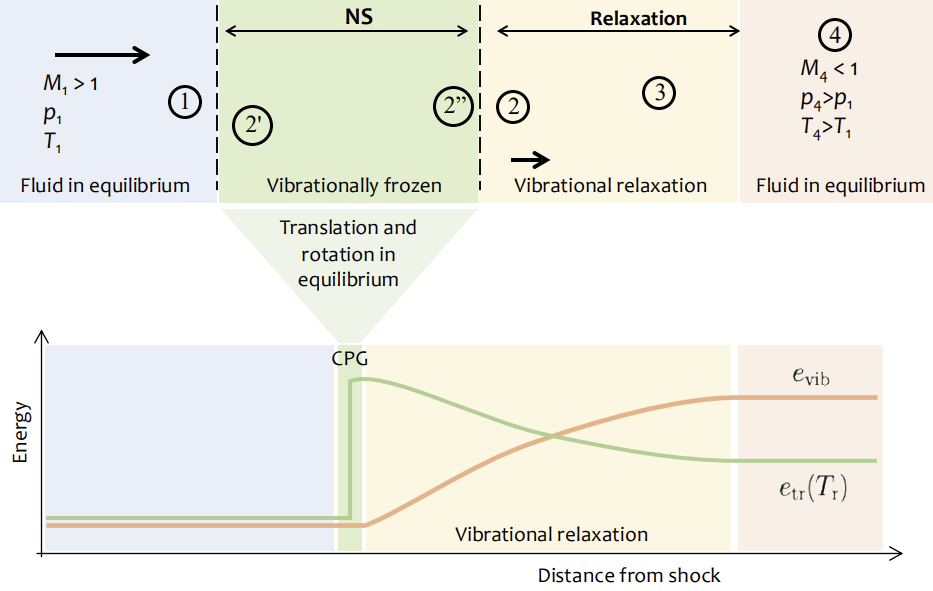

In this problem, we're asked to model the relaxation region after a normal shock using the continuity equations and the relaxation timescale model as proposed by Millikan and White (1963). The continuity equations in differential form are:
$$
\rho \frac{du}{dx} + u \frac{d\rho}{dx} = 0
$$
$$
\frac{dp}{dx} + \rho u \frac{du}{dx} = 0
$$
$$
\frac{dh}{dx} - \frac{1}{\rho} \frac{dp}{dx} = \frac{d(h^{*}+\frac{1}{2}u^2)}{dx} + \frac{d e_{vib}}{dx} = 0
$$
Enthalpy by definition is:
$$
h = e_{tr} + e_{rot} + e_{vib} + RT 
$$
For the vibrationally frozen enthalpy and given that our mixture is made of linear diatomic molecules:
$$
h^{*} = e^{*} + pv = e_{tr} + e_{rot} + RT = \frac{3}{2}RT + \frac{2}{2}RT + RT = \frac{7}{2}RT
$$
The Landau-Teller model for vibrational relaxation when applied to a 1D steady problem (re-expressed using the total derivative as shown in lecture) is:
$$
u \frac{d e_{vib}}{dx} = - \frac{e_{vib} - e^{*}_{vib}}{\tau_v(p, T)}
$$
where $e_{vib}$ is the actual amount of energy in the vibrational mode, $e^{*}_{vib}$ is the apparent vibrational energy (if evaluated at the local temperature, typically $T_{tr}$):
$$
e^{*}_{vib}(T_{tr}) = \frac{R\Theta_v}{e^{\Theta_v/T_r}-1}
$$
$\tau_v$ is the timescale from Millikan and White. The result of the Millikan and White paper is an empirically derived relationship:
$$
\ln(p\tau_v) = \left( 1.16 \times 10^{-3} \right) \mu^{\frac{1}{2}} \Theta_v^{\frac{4}{3}} \left( T^{-\frac{1}{3}} - 0.015\mu^{\frac{1}{4}} \right) - 18.42
$$
where $\mu$ is the reduced mass of the colliding pair, which given each has a molecular mass $m_1$ and $m_2$:
$$
\mu = \frac{m_1 m_2}{m_1 + m_2}
$$
$\Theta_v$ is the characteristic vibrational temperature, representing the quantum spacing of an internal mode (like vibration). For example: $\Theta_v = 3390 \textrm{ K}$ for $N_2$ and $\Theta_v = 2270 \textrm{ K}$ for $O_2$. Combining the energy equations:
$$
\left(
\frac{5}{2}u - \frac{7}{2}RT_{\mathrm{tr}}
\right)
\frac{du}{dx}
=
\sum_{i=1}^{N}
y_i\,
\frac{
e^{*}_{\mathrm{vib},i}(T_{\mathrm{tr}})
-
e_{\mathrm{vib},i}
}{
u\,\bar{\tau_i}(p,T)
}
$$
where $y_i$ is the mass fraction of species $i$ in the mixture.
The problem statement tells us to perform this relaxation assuming the medium is air, which is 21% $O_2$ and 79% $N_2$ by volume. This means that all possible collisions are between $O_2$-$O_2$, $N_2$-$N_2$, and $N_2$-$O_2$, and these processes occur at different rates. So for a species colliding with all possible partners, we can define an average relaxation time $\bar{\tau_i}$:
$$
\frac{1}{\bar{\tau_i}} = \sum_{j=1}^{N}{\frac{X_i}{\tau_{i-j}}}
$$
We will use the first order upwind finite difference scheme to break up the differentials:
$$
\frac{d\phi}{dx} = \frac{\phi_{k+1} - \phi_{k}}{\Delta x}
$$

Thus, we can solve the problem in this order:
1. Use Landau-Teller for each species to find the new $e_{vib}$ at state $k+1$ (we know the initial vibrational energy postshock from the preshock condition, since the mode is frozen across the NS)
2. Get $\bar{tau}$ for each species as a function of its collisions with other species
3. Solve numerically for the new velocity $u_{k+1}$
4. Use continuity to solve for $\rho_{k+1}$
5. Use continuity to solve for $p_{k+1}$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# First, establish mass fractions, mole fractions, and mixture properties
x_O2 = 0.21
x_N2 = 0.79
M_O2 = 32.00e-3
M_N2 = 28.01e-3
M_mix = x_O2 * M_O2 + x_N2 * M_N2
# Mass fractions
y_O2 = x_O2 * M_O2 / M_mix
y_N2 = x_N2 * M_N2 / M_mix
R_univ = 8.3145
R_O2 = R_univ / M_O2
R_N2 = R_univ / M_N2
R_mix = R_univ / M_mix
gamma_star = 7/5
theta_v_O2 = 2270
theta_v_N2 = 3390
mu_O2, mu_N2 = 16, 14
mu_N2_O2 = (mu_N2 * mu_O2) / (mu_N2 + mu_O2)

def get_thermalized_e_vib(theta_v, R, T_v):
    return (theta_v * R)/(np.exp(theta_v/T_v) - 1)

def get_tau_bar_i(T_tr, p, mu, theta_v):
    return (np.exp(1.16e-3 * mu**(1/2) * theta_v**(4/3) * (T_tr**(-1/3) - 0.015 * mu**(1/4)) - 18.42)) / p

# Inlet conditions
M1 = 10
p1 = 1.2e3
T1 = 227
a1 = np.sqrt(gamma_star * R_mix * T1)
u1 = M1 * a1
rho1 = p1 / (R_mix * T1)
# Across the NS, vibrationally frozen, equilibrium translational and rotational modes
p2 = p1 * (1 + (gamma_star/(1+gamma_star)) * (M1**2 - 1))
rho2 = rho1 * ((gamma_star+1) * M1**2)/(2 + (gamma_star-1) * M1**2)
u2 = u1 / ((gamma_star+1) * M1**2)/(2 + (gamma_star-1) * M1**2)
T2 = p2 / (rho2 * R_mix)
# Set up data collection
dx = 0.0001
x_range = np.linspace(0, dx, 0.1)
e_vib_o2 = np.zeros(len(x_range))
e_vib_n2 = np.zeros(len(x_range))
u = np.zeros(len(x_range))
rho = np.zeros(len(x_range))
p = np.zeros(len(x_range))
T = np.zeros(len(x_range))
# Input initial conditions
e_vib_o2[0] = get_thermalized_e_vib(theta_v_O2, R_O2, T1)
e_vib_n2[0] = get_thermalized_e_vib(theta_v_N2, R_N2, T1)
u[0], rho[0], p[0], T[0] = u2, rho2, p2, T2
for i in range(1, len(x_range)):
    pass
